## <font color='navy'> Examen 3. Laboratorio de Aprendizaje Estadístico.
    
### <font color='navy'> Modelos de Ensamble: Árboles y Boosting

Luis Fernando Márquez Bañuelos | 744489

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

pd.set_option('display.float_format', '{:,.4f}'.format)

## <font color='navy'> Importación de datos

In [2]:
data = pd.read_csv('hr_role.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


## <font color='navy'> Explicación de variables

El dataset **hr_role.csv** contiene variables relacionadas con empleados de una empresa, enfocadas en aspectos demográficos, laborales, financieros y de satisfacción. A continuación, se explica cada variable:

1. **Age**: Edad del empleado (en años).  
2. **Attrition**: Indica si el empleado ha dejado la empresa (*Yes/No*).  
3. **BusinessTravel**: Frecuencia de viajes por negocios (*Non-Travel, Travel_Rarely, Travel_Frequently*).  
4. **DailyRate**: Tarifa diaria de pago al empleado (valor monetario).  
5. **Department**: Departamento de trabajo (*Sales, Research & Development, Human Resources*).  
6. **DistanceFromHome**: Distancia desde el hogar al trabajo (en millas o kilómetros).  
7. **Education**: Nivel educativo (numérico: 1=bachillerato, 2=licenciatura, 3=maestría, 4=doctorado, etc.).  
8. **EducationField**: Campo de estudio (*Life Sciences, Medical, Marketing, Technical Degree, Other*).  
9. **EnvironmentSatisfaction**: Satisfacción con el entorno laboral (escala numérica: 1=bajo, 4=alto).  
10. **Gender**: Género (*Female, Male*).  
11. **HourlyRate**: Tarifa por hora del empleado (valor monetario).  
12. **JobInvolvement**: Nivel de involucramiento en el trabajo (escala numérica: 1=bajo, 4=alto).  
13. **JobLevel**: Nivel jerárquico del puesto (ej: 1=junior, 5=directivo).  
14. **JobRole**: Rol específico (*Sales Executive, Research Scientist, Laboratory Technician, etc.*).  
15. **MaritalStatus**: Estado civil (*Single, Married, Divorced*).  
16. **MonthlyIncome**: Salario mensual (valor monetario).  
17. **MonthlyRate**: Tasa mensual asociada al salario (valor monetario).  
18. **NumCompaniesWorked**: Número de empresas en las que ha trabajado previamente.  
19. **Over18**: Indica si el empleado es mayor de 18 años (*Y=Yes*, constante en este dataset).  
20. **OverTime**: Horas extras (*Yes/No*).  
21. **PercentSalaryHike**: Porcentaje de aumento salarial reciente.  
22. **PerformanceRating**: Evaluación de desempeño (ej: 3=bueno, 4=excelente).  
23. **RelationshipSatisfaction**: Satisfacción con las relaciones laborales (escala numérica: 1=bajo, 4=alto).  
24. **StandardHours**: Horas laborales estándar (constante: 80 horas).  
25. **StockOptionLevel**: Nivel de opciones de acciones asignadas (0=ninguno, 3=máximo).  
26. **TotalWorkingYears**: Años totales de experiencia laboral.  
27. **TrainingTimesLastYear**: Veces que recibió capacitación el último año.  
28. **WorkLifeBalance**: Balance entre trabajo y vida personal (escala numérica: 1=pobre, 4=excelente).  
29. **YearsAtCompany**: Años en la empresa actual.  
30. **YearsInCurrentRole**: Años en el puesto actual.  
31. **YearsSinceLastPromotion**: Años desde la última promoción.  
32. **YearsWithCurrManager**: Años trabajando con el gerente actual.  
33. **is_satisfied**: Indicador de satisfacción laboral (*True/False*).  

## <font color='navy'> Funciones

In [3]:
def histograma(probabilidades: np.ndarray, y_test: str):
    juntar = pd.DataFrame({
    'real': y_test,
    'probabilidades': probabilidades
    })
    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label = '1', color= 'skyblue')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label = '0', color = 'indianred')
    plt.title(f'Histograma de probabilidades de')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()

def curva_roc(probabilidades: np.ndarray, y_test: np.ndarray):
    fpr, fnp, _ = roc_curve(y_score=probabilidades, y_true=y_test)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, fnp, c='skyblue')
    plt.plot([0, 1], [0, 1], c='indianred')
    plt.title(f'Curva ROC')
    plt.show()

def feature_importance(X, model):
    importancia = pd.DataFrame({
    'variables': X.columns,
    'importancia': model.feature_importances_
    })
    importancia.sort_values('importancia', ascending=True, inplace=True)
    top5 = importancia.tail(5)
    top5.plot.barh(x='variables', y='importancia', color='skyblue', figsize=(10,6))
    for index, value in enumerate(top5['importancia']):
        plt.text(value, index, f'{value:.4f}', va='center')
    plt.xlabel('Importancia')
    plt.title('Top 5 Feature Importances')
    plt.show()

## <font color='navy'> Preparación de Datos

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  MaritalStatus           

Ninguna de las variables del dataset tiene datos nulos, por lo que no será necesario hacer limpieza de datos. Sin embargo se pueden poner multiples variables en un tipo más adecuado.

In [5]:
categorical_cols = [
    'BusinessTravel', 'Department', 'EducationField',
    'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime'
]

int8_cols = ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
             'JobInvolvement', 'JobLevel', 'RelationshipSatisfaction',
             'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance']

int32_cols = [
    'DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
    'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
    'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
    'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

data[int8_cols] = data[int8_cols].astype('int8')
data[int32_cols] = data[int32_cols].apply(pd.to_numeric, downcast='integer')
data[categorical_cols] = data[categorical_cols].astype('category')

In [6]:
data['Attrition'] = data['Attrition'].map({'Yes': True, 'No': False})
target = 'Attrition'
data = pd.get_dummies(data)

In [7]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## <font color='navy'> Árbol de Decisión

### <font color='navy'> Max Depth 2

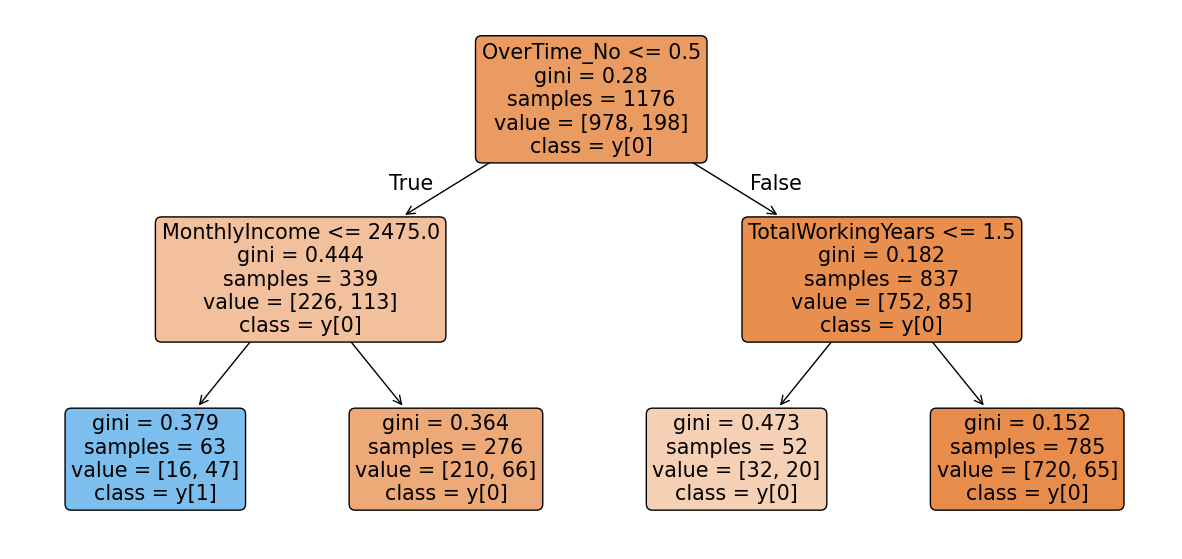

In [9]:
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
plt.figure(figsize=(15, 7))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, class_names=True);

bla bla bla

### <font color='navy'> Mejor Árbol

In [10]:
pipeline = Pipeline([
    ('tree', DecisionTreeClassifier(random_state=123))
])

params = {
    'tree__max_depth': list(range(1, 13)),
    'tree__min_samples_split': list(range(2, 10)),
    'tree__min_samples_leaf': list(range(1, 10)),
    'tree__max_features': ['sqrt', 'log2', None],
}

grid_tree = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc').fit(X_train, y_train)

In [11]:
grid_tree.best_params_

{'tree__max_depth': 4,
 'tree__max_features': 'log2',
 'tree__min_samples_leaf': 8,
 'tree__min_samples_split': 2}

In [12]:
best_model = grid_tree.best_estimator_.named_steps['tree']
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_tree = roc_auc_score(y_test, probabilidades)
print(f'AUC: {auc_tree:.4f}')

AUC: 0.6639


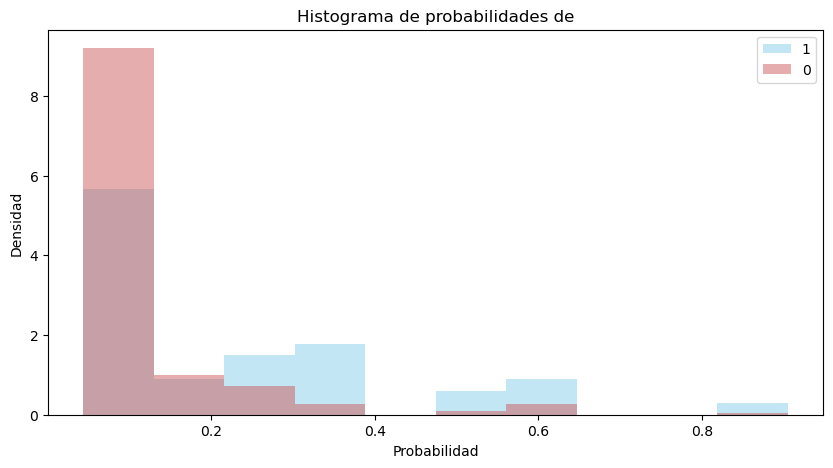

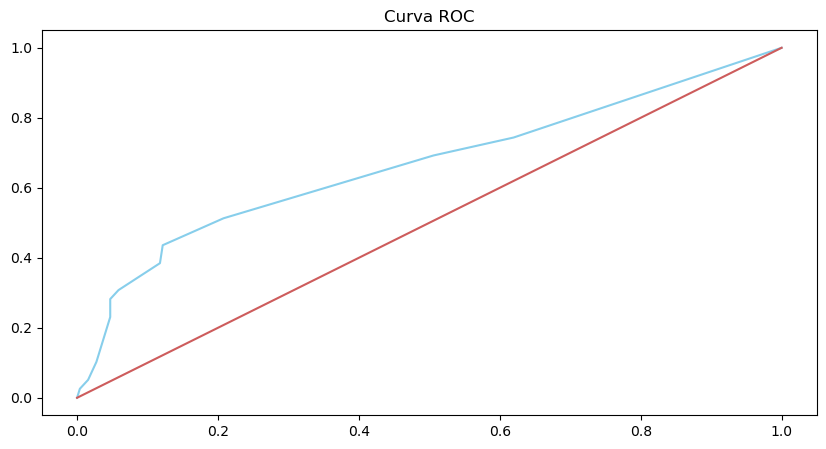

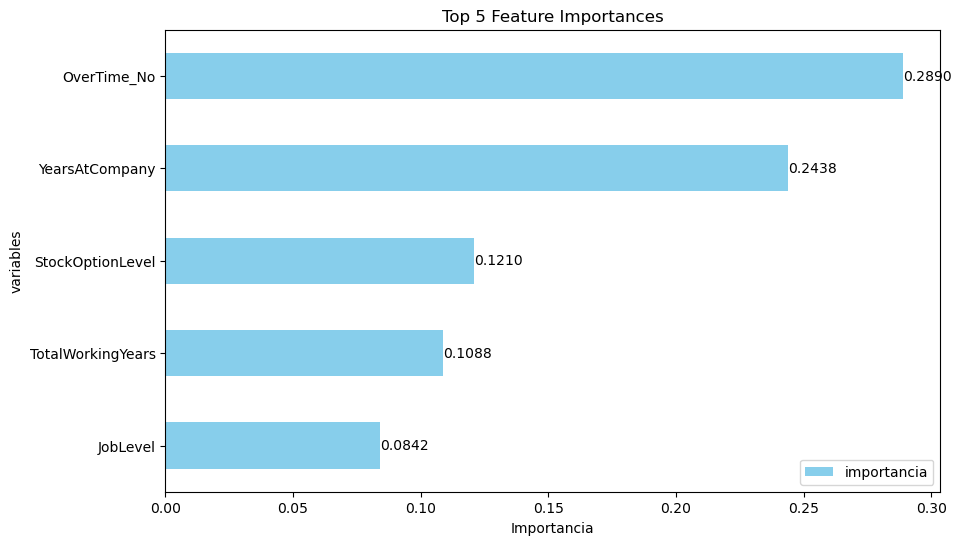

In [13]:
histograma(probabilidades, y_test)
curva_roc(probabilidades, y_test)
feature_importance(X, best_model)

## <font color='navy'> Random Forest

### <font color='navy'> Max Depth 2

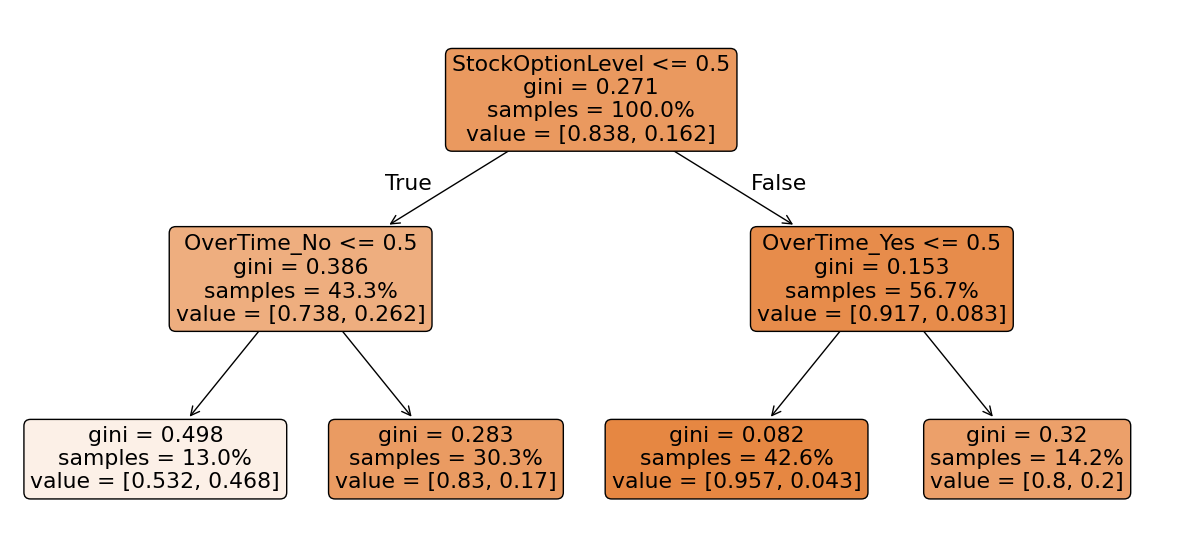

In [14]:
rf = RandomForestClassifier(max_depth=2, n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train)

plt.figure(figsize=(15, 7))
plot_tree(rf.estimators_[0], feature_names=X.columns, filled=True, rounded=True, proportion=True);

bla bla bla

### <font color='navy'> Mejor Random Forest

In [15]:
pipeline = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=123))
])

params = {
    'rf__max_depth': list(range(1, 13)),
    'rf__min_samples_split': list(range(2, 10)),
    'rf__max_features': ['sqrt', 'log2', None,  len(X_train.columns)*0.6],
}

grid_rf = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc').fit(X_train, y_train)

In [16]:
grid_rf.best_params_

{'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_split': 9}

In [17]:
best_model = grid_rf.best_estimator_.named_steps['rf']
probabilidades = best_model.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, probabilidades)
print(f'AUC: {auc_rf:.4f}')

AUC: 0.7398


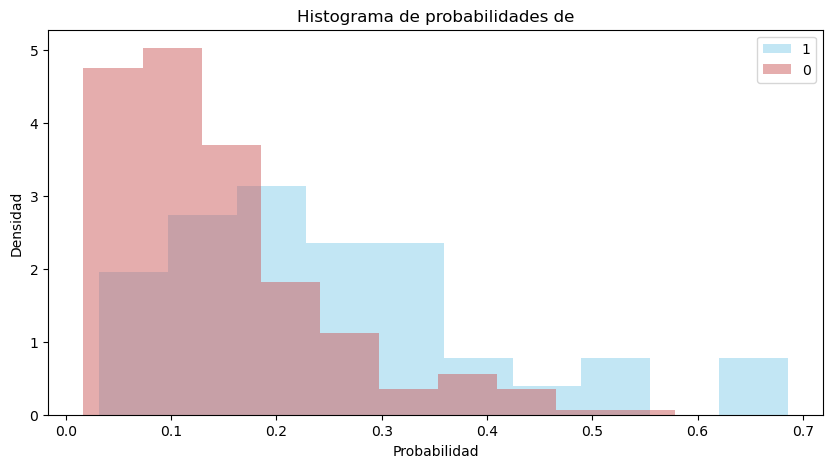

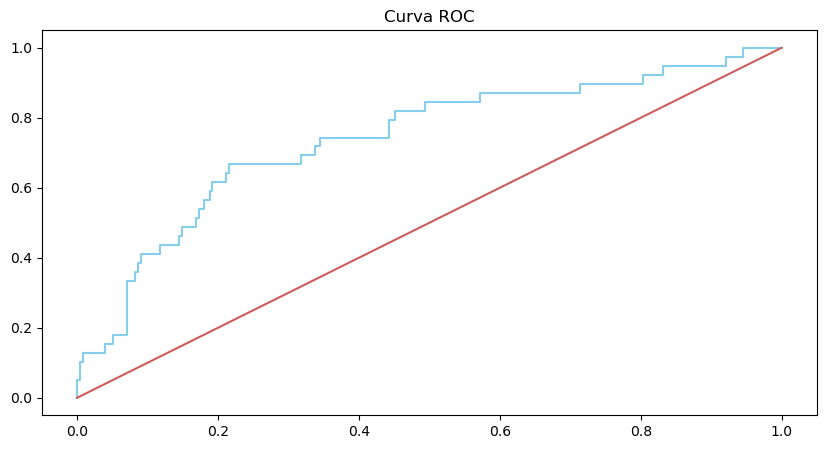

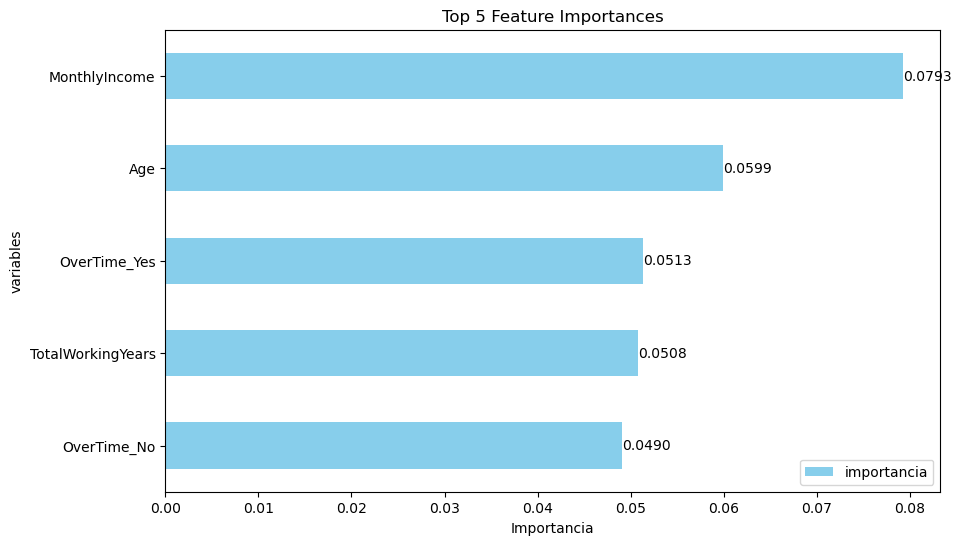

In [18]:
histograma(probabilidades, y_test)
curva_roc(probabilidades, y_test)
feature_importance(X, best_model)

## <font color='navy'> XGBoost

In [19]:
model = XGBClassifier(eval_metric='auc', n_jobs=-1, random_state=42 ,early_stopping_rounds=20)

params = {
    'n_estimators': [100, 200],
    'max_depth': list(range(1, 10)),
    'min_child_weight': [1, 2, 3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid_xgb = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        n_jobs=-1, cv=5, 
                        scoring='roc_auc').fit(X_train, y_train,
                                            eval_set=[(X_train, y_train), 
                                            (X_test, y_test)], verbose=0)

In [20]:
best_model = grid_xgb.best_estimator_
probabilidades = best_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {xgb_auc:.4f}')

AUC: 0.7944


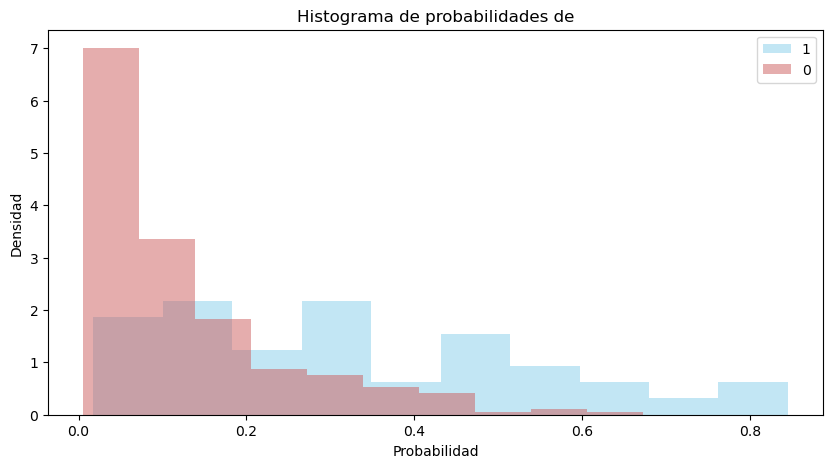

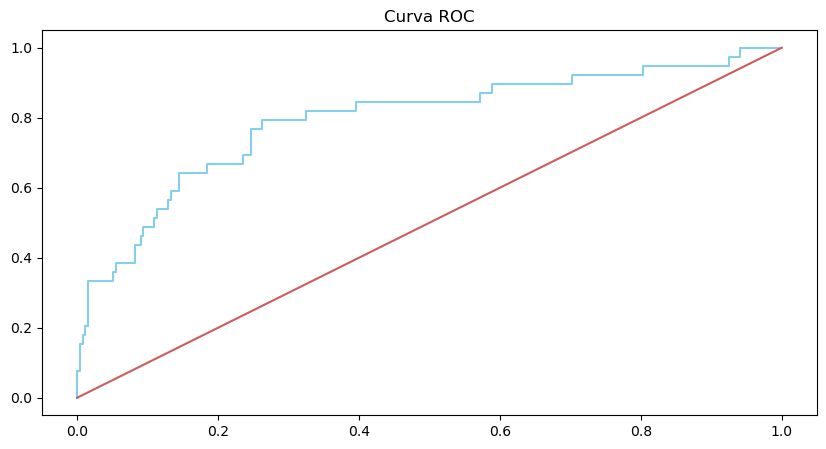

<Figure size 1000x600 with 0 Axes>

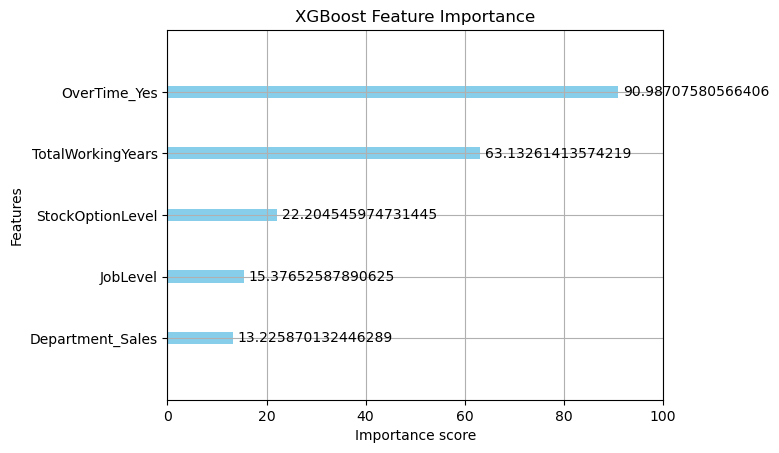

In [21]:
histograma(probabilidades, y_test)
curva_roc(probabilidades, y_test)
from xgboost import plot_importance
plt.figure(figsize=(10, 6))
plot_importance(best_model, max_num_features=5, importance_type='gain', title='XGBoost Feature Importance', color='skyblue')
plt.show()

## <font color='navy'> LightGBM

In [22]:
model = LGBMClassifier(
    n_estimators=200,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='auc',
    n_jobs=-1
)


model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='auc',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	training's auc: 0.991691	training's binary_logloss: 0.152619	valid_1's auc: 0.781197	valid_1's binary_logloss: 0.319638


LGBMClassifier(early_stopping_rounds=20, eval_metric='auc',
               feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
               n_estimators=200, n_jobs=-1, num_leaves=10, random_state=42,
               subsample=0.8, verbosity=-1)

In [23]:
probabilidades = model.predict_proba(X_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {lgbm_auc:.4f}')

AUC: 0.7812


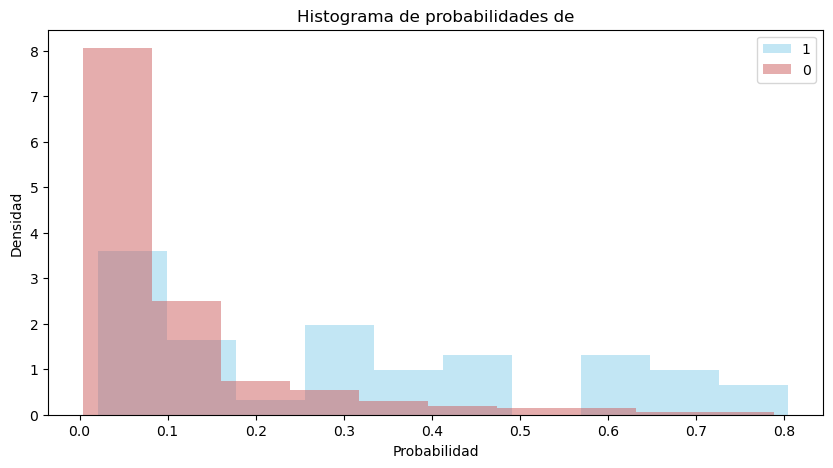

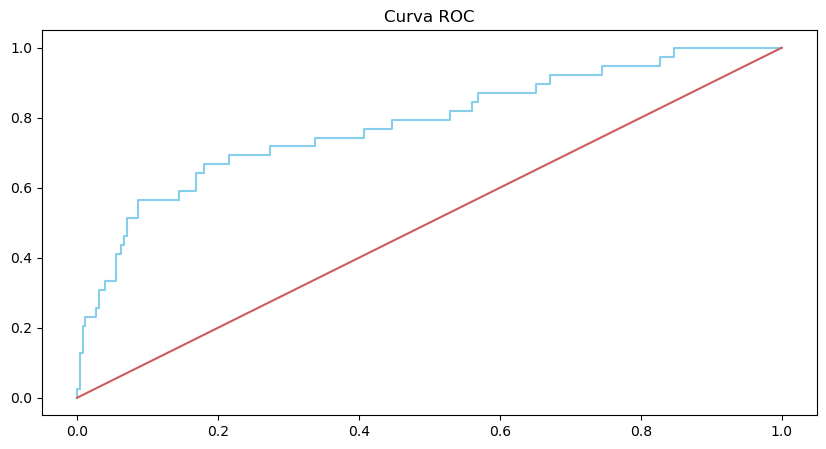

<Figure size 1000x600 with 0 Axes>

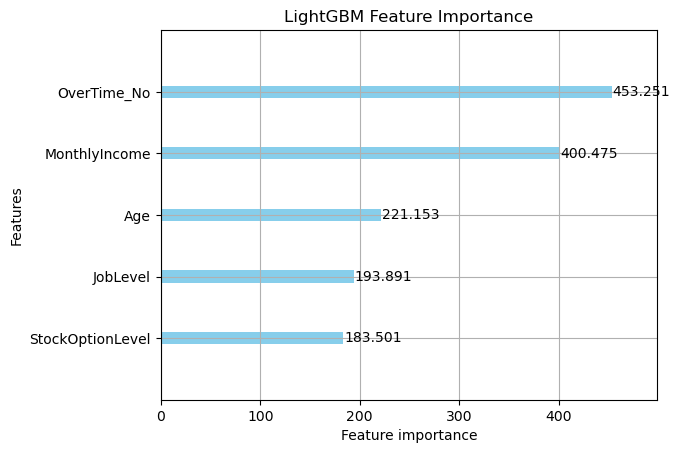

In [24]:
histograma(probabilidades, y_test)
curva_roc(probabilidades, y_test)
from lightgbm import plot_importance
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=5, importance_type='gain', title='LightGBM Feature Importance', color='skyblue')
plt.show()

## <font color='navy'> CatBoost

In [25]:
data = pd.read_csv('hr_role.csv')
data['Attrition'] = data['Attrition'].map({'Yes': True, 'No': False})
target = 'Attrition'
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paso 2: Detectar columnas categóricas (número bajo de categorías)
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]

# Paso 3: Forzar columnas categóricas a string y llenar nulos
for col in cat_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')

In [26]:
model = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    subsample=0.8,
    colsample_bylevel=0.8,
    eval_metric='AUC',
    random_state=42,
    early_stopping_rounds=20,
    verbose=100
)

model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=[(X_test, y_test)],
)

0:	test: 0.5125691	best: 0.5125691 (0)	total: 59ms	remaining: 11.7s
100:	test: 0.7618904	best: 0.7629965 (97)	total: 448ms	remaining: 439ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7688285571
bestIteration = 112

Shrink model to first 113 iterations.


In [27]:
probabilidades = model.predict_proba(X_test)[:, 1]
cat_auc = roc_auc_score(y_test, probabilidades)
print(f'AUC: {cat_auc:.4f}')

AUC: 0.7688


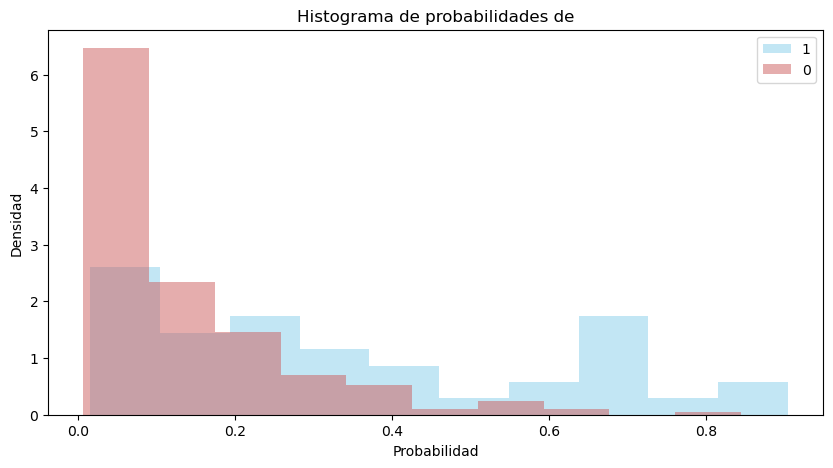

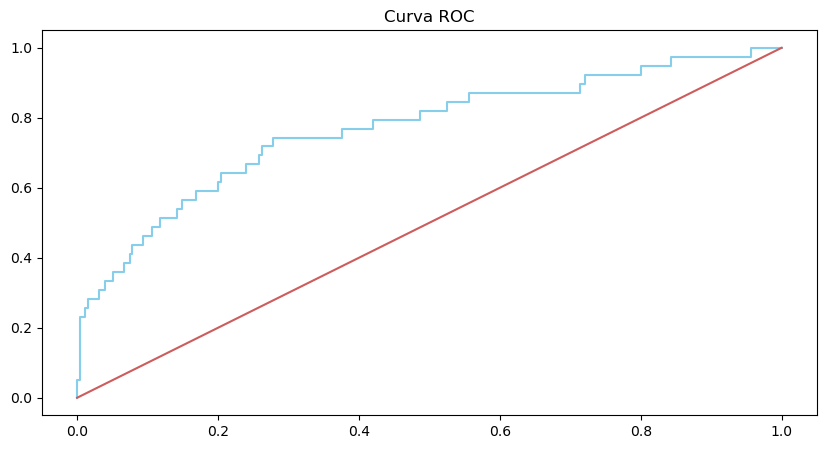

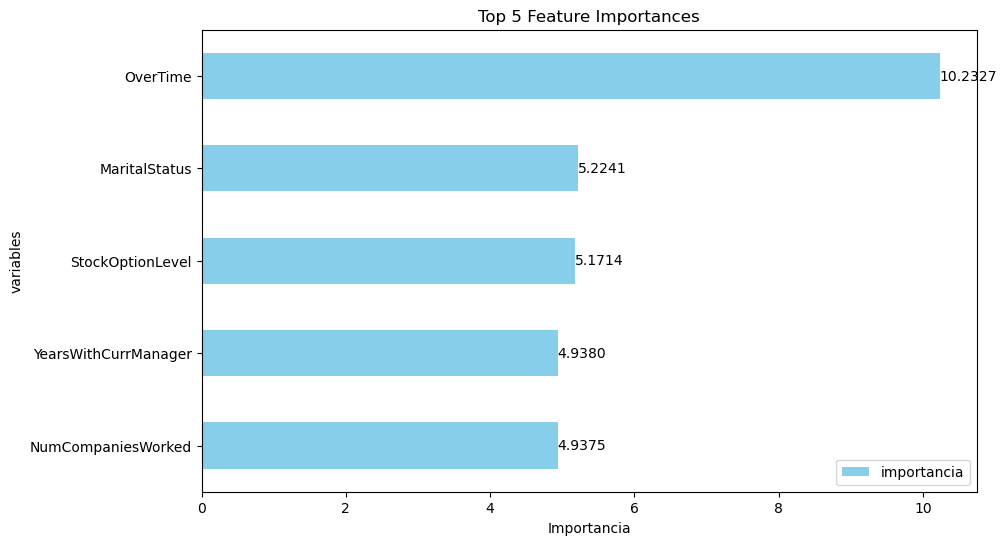

In [28]:
histograma(probabilidades, y_test)
curva_roc(probabilidades, y_test)
feature_importance(X, model)

## <font color='navy'> Mejor modelo y Conclusiones

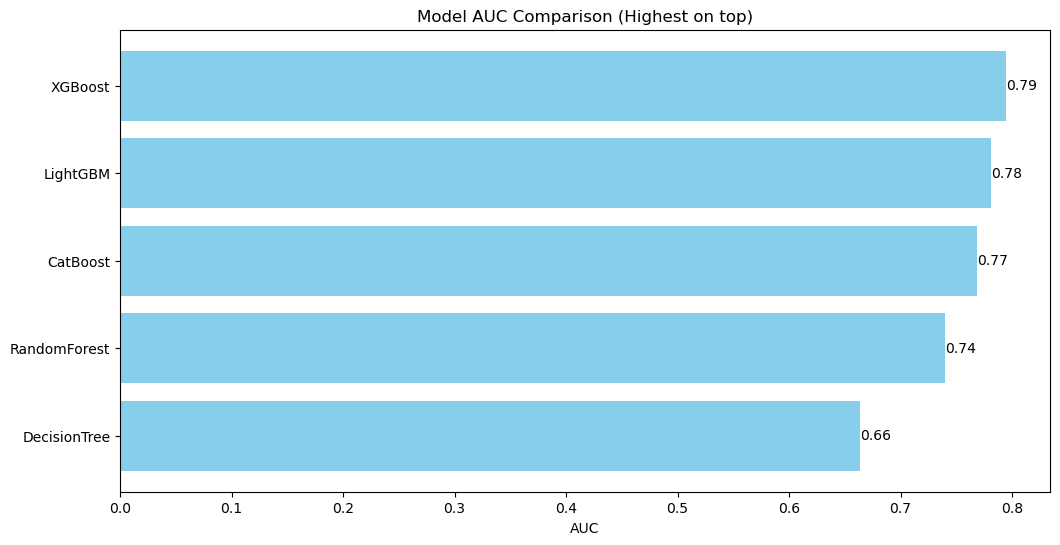

In [29]:
modelos = ['DecisionTree', 'RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
resultados = [auc_tree, auc_rf, xgb_auc, lgbm_auc, cat_auc]
resultados = pd.DataFrame({
    'modelos': modelos,
    'resultados': resultados
})

resultados = resultados.sort_values('resultados', ascending=True)
plt.figure(figsize=(12, 6))
plt.barh(resultados['modelos'], resultados['resultados'], color='skyblue')
for index, value in enumerate(resultados['resultados']):
    plt.text(value, index, f'{value:.2f}', va='center')
plt.xlabel('AUC')
plt.title('Model AUC Comparison (Highest on top)')
plt.show()